# TCSS 588 BioInformatics Project: Identifying key genes in NBL
## Siri Sadashiva

### README
#### The below cell installs all the required dependencies required to run for this notebook. If the installation fails, please install the following by running the commands in the terminal:

### Scikit
1. conda install scikit-learn (OR)
2. pip install -U scikit-learn

---------------------------------------------------------------------------------------------------------------------
### Matplotlib
1. conda install -c conda-forge matplotlib (OR)
2. pip install --upgrade setuptools 
   pip install matplotlib

---------------------------------------------------------------------------------------------------------------------


In [1]:
%matplotlib inline
!pip install --user scikit-learn

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import pydotplus
from clean import assay_transpose
from clean import manifest_clinical_merge
from clean import assay_clinical_merge
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from matplotlib_venn import venn2
from beautifultable import BeautifulTable
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,auc


# I. Data Preprocessing
### Please make sure to run the pd.read_csv command by specififying the correct directory that contains the csv file 

In [3]:
pd.options.mode.chained_assignment = None
manifest_df = pd.read_csv('../BioInformatics_Project/Manifest_Data/GCD_TARGET_Data_Manifest_AML_NBL_WT_RT.csv')
nbl_disc_df = pd.read_excel('../BioInformatics_Project/Clinical_Data/TARGET_NBL_ClinicalData_20151124.xlsx')
NBL_df = manifest_clinical_merge(manifest_df, nbl_disc_df, 'TARGET-NBL')
assay_df = pd.read_csv('../BioInformatics_Project/Expn_Data/TARGET_NBL_AML_RT_WT_TMMCPM_log2_Norm_Counts.csv.zip')
assay_t_df = assay_transpose(assay_df)
NBL_genes = assay_clinical_merge(assay_t_df, NBL_df)

In [4]:
NBL_genes['Risk_Group'] = NBL_genes['COG Risk Group'].apply(lambda x: 1 if x == 'Low Risk' else 0)


In [5]:
X = NBL_genes.iloc[:,53:-5]
y = NBL_genes.loc[NBL_genes.index,'Risk_Group']
X = X.apply(pd.to_numeric)

In [6]:
X.shape

(150, 21403)

In [7]:
y.value_counts()

0    136
1     14
Name: Risk_Group, dtype: int64

#### Total count of:  Risk_Group 'Low' = 60;  Risk_Group 'High' = 77

# II. Feature Selection: Correlation
### Calculating correlation coefficients for all the genes

In [8]:
correlation_matrix = X.corr()

In [9]:
#Get highly correlated co-efficients
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.80)]

#drop highly correlated coefficients 
for i in to_drop:
    del X[i]
    
X.shape

(150, 17556)

### After feature selection, we have 17556 genes out of 21403 genes

# III. Modeling

### Split the data into test and train sets 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=8)

In [11]:
#Initialize K-Fold: k = 10
kf = KFold(n_splits=10,shuffle=True)

#Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100)

#Initialize predictions
predictions =[]

#Run 10 times
for k, (train, test) in enumerate(kf.split(X, y)):
    #Fit and train the model
    clf.fit(X_train,y_train)
    
    #Get the prediction
    predictions.append(clf.score(X_test, y_test))

### Calculate Metrics

Accuracy of the Random Forest Classifier is 
0.93
------------------------------------------------
Confusion Matrix:
[[46  0]
 [ 3  1]]
------------------------------------------------
Classification Report:
             precision    recall  f1-score   support

          0       0.94      1.00      0.97        46
          1       1.00      0.25      0.40         4

avg / total       0.94      0.94      0.92        50

------------------------------------------------


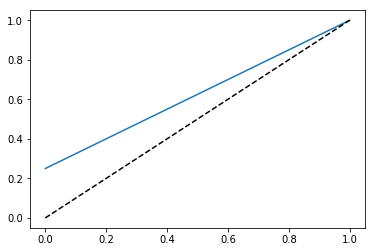

Area under curve (AUC):  0.625


In [12]:
#Accuracy 
print("Accuracy of the Random Forest Classifier is ")
print(sum(predictions) / float(len(predictions)))
print("------------------------------------------------")

#Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, clf.predict(X_test)))
print("------------------------------------------------")

#Classification Report
print("Classification Report:")
print(classification_report(y_test, clf.predict(X_test)))
print("------------------------------------------------")

#Area Under Curve 
y_score = clf.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.plot(fpr,tpr)
plt.plot((0,1), ls='dashed',color='black')
plt.show()
print ('Area under curve (AUC): ', auc(fpr,tpr))


### Feature Importance: Top 10 Genes

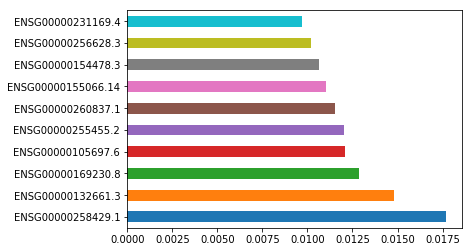

In [13]:
(pd.Series(clf.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh')) 